# Gather and Wrangle: We Rate Dogs Twitter Archive


**The goal of this project is to gather and clean data from the We Rate Dogs twitter acount. **

**The three datasets are:**
1. The twitter archive of WeRateDogs
2. Tweet image predictions of the dogs in the pictures according to a neural network
3. Each tweets favorite and retweet counts

**The three data sets will be downloaded in different ways:**
1. Twitter archive - Manually downloaded
2. Tweet image predictions-Programatically downloaded with the python requests library
3. Tweet favorite and retweet counts - Obtained from the Twitter API. 

Resources:
The tweet data dictionary is very helpful for deciphering the keys within the twitter JSON.  
https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html  
https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/  
https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python  
https://wiki.python.org/moin/HandlingExceptions
https://gist.github.com/paulochf/f6c9ed0b39f85dd85270
https://stackoverflow.com/questions/6633678/finding-words-after-keyword-in-python

# 1. Gather the data. 
First load required packaged. Pandas for Pandas library, requests to load things programmatically with a url,
tweepy to access twitter API (this first needs to be installed in your ipython environment via pip install tweepy) and os to access parts of your operating system directory

In [205]:
import pandas as pd
import tweepy, os, json, requests, time, re
import numpy as np

from functools import reduce
#from load_api import load_api

from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
%run load_api.py

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#expand column width to view the text output better
pd.set_option('max_colwidth', 150)


**1A. load the data that were manually downloaded. These data were obtained from the WeRateDogs twitter account managers who downloaded these data and made it available for students in the class.**

In [206]:
df_arch = pd.read_csv('Data/twitter-archive-enhanced.csv')
df_arch.head()
#df_arch.retweeted_status_id.value_counts()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [4]:
df_arch.shape

(2356, 17)

**1B. Programmatically download the image prediction data.**

In [207]:
#url of where the data are
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

#now save the file to the computer
#put the data in the Data folder
folder_name = 'Data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)
    
#load them as a datafame
image_df = pd.read_csv('Data/image-predictions.tsv', sep='\t')
image_df.head()
image_df.shape

(2075, 12)

**1C. Get twitter data.**  
Create API object to use to get the Twitter data.  I have used a function to do this so as not to share my Twitter consumer key and access token.

In [606]:
api = load_api()

id_test = df_arch.tweet_id.iloc[0]
print(id_test)

#obtain tweet with info
tweet = api.get_status(id_test, tweet_mod='extended')

#entire JSON 
#print(tweet)
#tweet text
print(tweet.text)
#how many times the tweet has been retweeted
print(tweet.retweet_count)
#how many times the tweet has been favorited
print(tweet.favorite_count)
#how many followers the user has at the time of the tweet
print(tweet.user.followers_count)
#print(df_arch.tweet_id)

892420643555336193
This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
8256
37841
7804967


**Query each tweet id and write its JSON data to the required tweet_json.txt file. Then read the txt file line by line to make a pandas DataFrame.**

Tips:

1. Try-except blocks may come in handy here.
2. Printing out each tweet ID after it was queried 
3. Using a code timer were both helpful 
4. Setting the wait_on_rate_limit and wait_on_rate_limit_notify parameters to True in the tweepy.api class is useful as well.



In [119]:
#loop through each tweet id in the dr_arch df


start = time.time()
print("starting")

data = []
tweet_errors = {}
for id in df_arch.tweet_id:
    try:
        tweet = api.get_status(id, tweet_mod='extended')
        print(tweet.id)
        date = tweet.created_at
        new_date = date.strftime('%Y-%m-%d %H-%M-%S')
        rt_ct = tweet.retweet_count
        fav_ct = tweet.favorite_count
        flr_ct = tweet.user.followers_count
        data.append({'id':tweet.id, 'date': new_date, 'retweet_cnt':rt_ct, "favorite_cnt": fav_ct, "followers":flr_ct})
        
        
    except Exception as e:
        print(str(tweet.id)+str(e))
        tweet_errors[tweet.id] = tweet.id
        

end = time.time()
print("total time elapsed = " + str(end - start))


starting
892420643555336193
892177421306343426
891815181378084864
891689557279858688
891327558926688256
891087950875897856
890971913173991426
890729181411237888
890609185150312448
890240255349198849
890006608113172480
889880896479866881
889665388333682689
889638837579907072
889531135344209921
889278841981685760
888917238123831296
888804989199671297
888554962724278272
888554962724278272[{'code': 144, 'message': 'No status found with that ID.'}]
888078434458587136
887705289381826560
887517139158093824
887473957103951883
887343217045368832
887101392804085760
886983233522544640
886736880519319552
886680336477933568
886366144734445568
886267009285017600
886258384151887873
886054160059072513
885984800019947520
885528943205470208
885518971528720385
885311592912609280
885167619883638784
884925521741709313
884876753390489601
884562892145688576
884441805382717440
884247878851493888
884162670584377345
883838122936631299
883482846933004288
883360690899218434
883117836046086144
882992080364220416
8

824775126675836928
824663926340194305
824325613288833024
824297048279236611
824025158776213504
823939628516474880
823719002937630720
823699002998870016
823581115634085888
823333489516937216
823322678127919110
823269594223824897
822975315408461824
822872901745569793
822859134160621569
822647212903690241
822610361945911296
822489057087389700
822462944365645825
822244816520155136
822163064745328640
821886076407029760
821813639212650496
821765923262631936
821522889702862852
821421320206483457
821407182352777218
821153421864615936
821149554670182400
821107785811234820
821044531881721856
820837357901512704
820749716845686786
820690176645140481
820494788566847489
820446719150292993
820314633777061888
820078625395449857
820013781606658049
819952236453363712
819924195358416896
819711362133872643
819588359383371776
819347104292290561
819238181065359361
819227688460238848
819015337530290176
819015331746349057
819006400881917954
819004803107983360
818646164899774465
818627210458333184
818614493328

770655142660169732
770414278348247044
770293558247038976
770093767776997377
770069151037685760
769940425801170949
769695466921623552
769335591808995329
769212283578875904
768970937022709760
768909767477751808
768855141948723200
768609597686943744
768596291618299904
768554158521745409
768473857036525572
768193404517830656
767884188863397888
767754930266464257
767500508068192258
767191397493538821
767122157629476866
766864461642756096
766793450729734144
766714921925144576
766693177336135680
766423258543644672
766313316352462849
766078092750233600
766069199026450432
766008592277377025
765719909049503744
765669560888528897
765395769549590528
765371061932261376
765222098633691136
764857477905154048
764259802650378240
763956972077010945
763837565564780549
763183847194451968
763167063695355904
763103485927849985
762699858130116608
762471784394268675
762464539388485633
762316489655476224
762035686371364864
761976711479193600
761750502866649088
761745352076779520
761672994376806400
761599872357

Rate limit reached. Sleeping for: 369


759446261539934208
759197388317847553
759159934323924993
759099523532779520
759047813560868866
758854675097526272
758828659922702336
758740312047005698
758474966123810816
758467244762497024
758405701903519748
758355060040593408
758099635764359168
758041019896193024
757741869644341248
757729163776290825
757725642876129280
757611664640446465
757597904299253760
757596066325864448
757400162377592832
757393109802180609
757354760399941633
756998049151549440
756939218950160384
756651752796094464
756526248105566208
756303284449767430
756288534030475264
756275833623502848
755955933503782912
755206590534418437
755110668769038337
754874841593970688
754856583969079297
754747087846248448
754482103782404096
754449512966619136
754120377874386944
754120377874386944[{'code': 144, 'message': 'No status found with that ID.'}]
753655901052166144
753420520834629632
753398408988139520
753375668877008896
753298634498793472
753294487569522689
753039830821511168
753026973505581056
752932432744185856
7529172845

706291001778950144
706265994973601792
706169069255446529
706166467411222528
706153300320784384
705975130514706432
705970349788291072
705898680587526145
705786532653883392
705591895322394625
705475953783398401
705442520700944385
705428427625635840
705239209544720384
705223444686888960
705102439679201280
705066031337840642
704871453724954624
704859558691414016
704847917308362754
704819833553219584
704761120771465216
704499785726889984
704491224099647488
704480331685040129
704364645503647744
704347321748819968
704134088924532736
704113298707505153
704054845121142784
703774238772166656
703769065844768768
703631701117943808
703611486317502464
703425003149250560
703407252292673536
703382836347330562
703356393781329922
703268521220972544
703079050210877440
703041949650034688
702932127499816960
702899151802126337
702684942141153280
702671118226825216
702598099714314240
702539513671897089
702332542343577600
702321140488925184
702276748847800320
702217446468493312
701981390485725185
701952816642

678969228704284672
678800283649069056
678798276842360832
678774928607469569
678767140346941444
678764513869611008
678755239630127104
678740035362037760
678708137298427904
678675843183484930
678643457146150913
678446151570427904
678424312106393600
678410210315247616
678399652199309312
678396796259975168
678389028614488064
678380236862578688
678341075375947776
678334497360859136
678278586130948096
678255464182861824
678023323247357953
678021115718029313
677961670166224897
677918531514703872
677895101218201600
677716515794329600
677700003327029250
677698403548192770
677687604918272002
677673981332312066
677662372920729601
677644091929329666
677573743309385728
677565715327688705
677557565589463040
677547928504967168
677530072887205888
677335745548390400
677334615166730240
677331501395156992


Rate limit reached. Sleeping for: 706


677328882937298944
677314812125323265
677301033169788928
677269281705472000
677228873407442944
677187300187611136
676975532580409345
676957860086095872
676949632774234114
676948236477857792
676946864479084545
676942428000112642
676936541936185344
676916996760600576
676897532954456065
676864501615042560
676821958043033607
676819651066732545
676811746707918848
676776431406465024
676617503762681856
676613908052996102
676606785097199616
676603393314578432
676593408224403456
676590572941893632
676588346097852417
676582956622721024
676575501977128964
676533798876651520
676496375194980353
676470639084101634
676440007570247681
676430933382295552
676263575653122048
676237365392908289
676219687039057920
676215927814406144
676191832485810177
676146341966438401
676121918416756736
676101918813499392
676098748976615425
676089483918516224
675898130735476737
675891555769696257
675888385639251968
675878199931371520
675870721063669760
675853064436391936
675849018447167488
675845657354215424
675822767435

668268907921326080
668256321989451776
668248472370458624
668237644992782336
668226093875376128
668221241640230912
668204964695683073
668190681446379520
668171859951755264
668154635664932864
668142349051129856
668113020489474048
667937095915278337
667924896115245057
667915453470232577
667911425562669056
667902449697558528
667886921285246976
667885044254572545
667878741721415682
667873844930215936
667866724293877760
667861340749471744
667832474953625600
667806454573760512
667801013445750784
667793409583771648
667782464991965184
667773195014021121
667766675769573376
667728196545200128
667724302356258817
667550904950915073
667550882905632768
667549055577362432
667546741521195010
667544320556335104
667538891197542400
667534815156183040
667530908589760512
667524857454854144
667517642048163840
667509364010450944
667502640335572993
667495797102141441
667491009379606528
667470559035432960
667455448082227200
667453023279554560
667443425659232256
667437278097252352
667435689202614272
667405339315

**1D. Serialize json data and save to a text file**

In [508]:
#serialize json data and save to text file
with open(os.path.join(folder_name,'tweet_json.txt'), mode='w') as outfile:  
    json.dump(data, outfile)

**1E. Open the saved json file and convert to a pandas dataframe**

In [208]:
#open the saved json file
with open(os.path.join(folder_name,'tweet_json.txt')) as f:
    json_df = json.load(f)


#convert the json_data file to a pandas data frame 
json_df = pd.DataFrame(json_df, columns=['id', 'date', 'retweet_cnt', 'favorite_cnt', 'followers'])


In [209]:
json_df

,id,date,retweet_cnt,favorite_cnt,followers
0,892420643555336193,2017-08-01 16-23-56,8259,37853,7794034
1,892177421306343426,2017-08-01 00-17-27,6103,32526,7794034
2,891815181378084864,2017-07-31 00-18-03,4041,24490,7794034
3,891689557279858688,2017-07-30 15-58-51,8410,41206,7794034
4,891327558926688256,2017-07-29 16-00-24,9108,39388,7794034
5,891087950875897856,2017-07-29 00-08-17,3027,19798,7794034
6,890971913173991426,2017-07-28 16-27-12,2000,11572,7794034
7,890729181411237888,2017-07-28 00-22-40,18343,63873,7794034
8,890609185150312448,2017-07-27 16-25-51,4160,27208,7794034
9,890240255349198849,2017-07-26 15-59-51,7175,31199,7794034


# 2. Assess the data.

Look for issues specifically related to the ratings, the dog names, and dog stages. 

In [210]:
df_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 5 columns):
id              2340 non-null int64
date            2340 non-null object
retweet_cnt     2340 non-null int64
favorite_cnt    2340 non-null int64
followers       2340 non-null int64
dtypes: int64(4), object(1)
memory usage: 91.5+ KB


In [10]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [15]:
df_arch.tweet_id.duplicated().sum(), df_arch.duplicated().sum(), json_df.id.duplicated().sum(), image_df.tweet_id.duplicated().sum()

(0, 0, 0, 0)

In [16]:
df_arch[['text', 'name', 'rating_numerator', 'rating_denominator','doggo', 'floofer', 'pupper', 'puppo']].sample(20)

,text,name,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo
1863,"The tail alone is 13/10. Great dog, better owner https://t.co/IyAXinfyju",None,13,10,None,None,None,None
1753,Here's a pupper with some mean tan lines. Snazzy sweater though 12/10 https://t.co/DpCSVsl6vu,None,12,10,None,None,pupper,None
420,RT @dog_rates: This is Mattie. She's extremely dangerous. Will bite your h*ckin finger right off. Still 11/10 would pet with caution https:…,Mattie,11,10,None,None,None,None
2312,This is Josep. He is a Rye Manganese mix. Can drive w eyes closed. Very irresponsible. Menace on the roadways. 5/10 https://t.co/XNGeDwrtYH,Josep,5,10,None,None,None,None
1359,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,Socks,9,10,None,None,None,None
2264,This is a southwest Coriander named Klint. Hat looks expensive. Still on house arrest :(\n9/10 https://t.co/IQTOMqDUIe,a,9,10,None,None,None,None
208,This is Wiggles. She would like you to spot her. Probably won't need your help but just in case. 13/10 powerful as h*ck https://t.co/2d370P0OEg,Wiggles,13,10,None,None,None,None
847,RT @dog_rates: This is Colby. He's currently regretting all those times he shook your hand for an extra treat. 12/10 https://t.co/vtVHtKFtBH,Colby,12,10,None,None,None,None
1191,This is Barclay. His father was a banana. 11/10 appeeling af https://t.co/ucOEfr2rjV,Barclay,11,10,None,None,None,None
687,Did... did they pick out that license plate? 12/10 for both https://t.co/lRmUUOxgbQ,None,12,10,None,None,None,None


In [17]:
df_arch.name.value_counts()

None            745
a                55
Charlie          12
Lucy             11
Oliver           11
Cooper           11
Tucker           10
Lola             10
Penny            10
Bo                9
Winston           9
Sadie             8
the               8
an                7
Buddy             7
Toby              7
Bailey            7
Daisy             7
Jack              6
Milo              6
Bella             6
Koda              6
Oscar             6
Leo               6
Rusty             6
Dave              6
Jax               6
Stanley           6
Scout             6
Bentley           5
               ... 
Enchilada         1
Darla             1
Shadoe            1
Aja               1
Ike               1
Florence          1
Eleanor           1
Cleopatricia      1
Goliath           1
Zeus              1
Sundance          1
Mona              1
Zeek              1
Gunner            1
Tess              1
Bonaparte         1
Skittles          1
Jessiga           1
Coopson           1


In [19]:
df_arch.rating_numerator.value_counts()
df_arch.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [20]:
df_arch[df_arch['name'] == 'None'][['text', 'name']].sample(20)

,text,name
1111,"""Ello this is dog how may I assist"" ...10/10 https://t.co/jeAENpjH7L",None
1343,This pupper killed this great white in an epic sea battle. Now wears it as a trophy. Such brave. Much fierce. 13/10 https://t.co/Lu0ECu5tO5,None
1075,Here's a doggo that don't need no human. 12/10 independent af (vid by @MichelleLiuCee) https://t.co/vdgtdb6rON,None
1200,There has clearly been a mistake. Pup did nothing wrong. 12/10 would help escape\nhttps://t.co/Juid3nnLbC,None
2186,Unique dog here. Oddly shaped tail. Long pink front legs. I don't think dogs breath underwater sos. 4/10 bad owner https://t.co/0EJXxE9UxW,None
1464,"This pupper only appears through the hole of a Funyun. Much like Phineas, this one is also mysterious af. 10/10 https://t.co/SQsEBWxPyG",None
537,"""Good afternoon class today we're going to learn what makes a good boy so good"" 13/10 https://t.co/f1h2Fsalv9",None
1861,Rare shielded battle dog here. Very happy about abundance of lettuce. Painfully slow fetcher. Still petable. 5/10 https://t.co/C3tlKVq7eO,None
1844,This dog is being demoted to a 9/10 for not wearing a helmet while riding. Gotta stay safe out there. Thank you,None
1811,Watch out Airbud. This pupper is also good at the sports. 12/10 I'm thinking D1 https://t.co/1HrFdo7M0C,None


#### Dirty Data Issues:
1. Some retweets present (RT @ ...)
2. Some replies to other users present   
3. 55 names 'a', 7 names 'an' , 7 names 'the' 
4. Some none recordings when a name is available: Index 240: Name is recorded as None when name should be Atlas,    Index 1414: Name is recorded as None when should be Thea, Index 122, Index 129
5. Several rows with rating denominators wrong (962, 996, 1400, 2046, 871), 2 rows with rating denominator below    10 (likely mistake)
6. Text and http url are joined together in the text column
7. timestamp and retweeted_status_timestamp datatypes are strs (object)
8. Many unnecessary columns


#### Untidy Data Issues:
1. Datasets in separate dataframes
2. Dogger, floofer, pupper, and puppo seperate columns when should be in one column (stage). 
3. Rating is in separate columns  (numerator and denominator)



# 3. Clean The Data


First join the datasets together to address the untidy nature of them being separate. Once they are joined together then I can address the dirty data issues and the remaining tidiness issues. 

In [211]:
#change name of json_df column id
json_df_new = json_df.rename(columns={'id': 'tweet_id'})
json_df.head()


,id,date,retweet_cnt,favorite_cnt,followers
0,892420643555336193,2017-08-01 16-23-56,8259,37853,7794034
1,892177421306343426,2017-08-01 00-17-27,6103,32526,7794034
2,891815181378084864,2017-07-31 00-18-03,4041,24490,7794034
3,891689557279858688,2017-07-30 15-58-51,8410,41206,7794034
4,891327558926688256,2017-07-29 16-00-24,9108,39388,7794034


In [212]:
#join together and join on the right (json_df) so that it retains only the tweets that have a retweet and like count
new_df = df_arch.merge(json_df_new, on='tweet_id',how='right')

new_df.head()
new_df.info()
new_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2339
Data columns (total 21 columns):
tweet_id                      2340 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2340 non-null object
source                        2340 non-null object
text                          2340 non-null object
retweeted_status_id           167 non-null float64
retweeted_status_user_id      167 non-null float64
retweeted_status_timestamp    167 non-null object
expanded_urls                 2281 non-null object
rating_numerator              2340 non-null int64
rating_denominator            2340 non-null int64
name                          2340 non-null object
doggo                         2340 non-null object
floofer                       2340 non-null object
pupper                        2340 non-null object
puppo                         2340 non-null object
date                          23

(2340, 21)

In [213]:
#now join the image predictions
df = new_df.merge(image_df, on='tweet_id')
df.info()
df.shape
#adding the image predictions reduced the tweets from 2340 to 2067

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 0 to 2066
Data columns (total 32 columns):
tweet_id                      2067 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2067 non-null object
source                        2067 non-null object
text                          2067 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null object
expanded_urls                 2067 non-null object
rating_numerator              2067 non-null int64
rating_denominator            2067 non-null int64
name                          2067 non-null object
doggo                         2067 non-null object
floofer                       2067 non-null object
pupper                        2067 non-null object
puppo                         2067 non-null object
date                          2067 

(2067, 32)

In [261]:
#make a copy of the dataset, work on the new one (df1)
df1 = df.copy()

### Dirty Data Issues
1. Remove the retweets by selecting only the null retweeted status ids

In [262]:
df1 = df1[df1.retweeted_status_id.isnull()]

In [263]:
#test
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 2066
Data columns (total 32 columns):
tweet_id                      1992 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1992 non-null object
source                        1992 non-null object
text                          1992 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1992 non-null object
rating_numerator              1992 non-null int64
rating_denominator            1992 non-null int64
name                          1992 non-null object
doggo                         1992 non-null object
floofer                       1992 non-null object
pupper                        1992 non-null object
puppo                         1992 non-null object
date                          1992 non

2. Remove the replies by selecting only null in_reply_to_user_id

In [264]:
df1 = df1[df1.in_reply_to_user_id.isnull()]

In [265]:
#test
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2066
Data columns (total 32 columns):
tweet_id                      1969 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1969 non-null object
source                        1969 non-null object
text                          1969 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1969 non-null object
rating_numerator              1969 non-null int64
rating_denominator            1969 non-null int64
name                          1969 non-null object
doggo                         1969 non-null object
floofer                       1969 non-null object
pupper                        1969 non-null object
puppo                         1969 non-null object
date                          1969 non-n

3. Fix the 55 names that were assigned 'a', 7 names 'an' , 7 names 'an' by replacing the with their correct name

In [266]:
df1[df1['name'] =='a'][['text', 'name']]

,text,name
50,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/g...,a
519,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
642,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
817,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,a
819,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,a
828,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,a
854,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,a
990,People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n,a
1000,This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10 https://t.co/cxl6xGY8B9,a
1117,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu,a


In [267]:
#many of these have a name that follows the text 'named'- use this name or just replace with None. 

In [268]:
a_name = df1[df1['name'] == 'a']
a_name.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
50,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,...,1,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False
519,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.co...",...,4,web_site,0.226716,False,lighter,0.081941,False,switch,0.039009,False
642,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.co...",...,3,Newfoundland,0.574345,True,Border_collie,0.128352,True,Saint_Bernard,0.059476,True
817,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/747885874273214464/photo/1,https://twitter.com/dog_rates/status/747885874273214464/photo/1",...,1,kuvasz,0.408450,True,Samoyed,0.141330,True,pug,0.083018,True
819,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857231626240/photo/1,...,1,Pembroke,0.768923,True,Chihuahua,0.029053,True,Shetland_sheepdog,0.029035,True


In [269]:
a_new = a_name[a_name['text'].str.contains('name*')]
a_new

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1257,692187005137076224,NaN,NaN,2016-01-27 03:26:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a rare Arctic Wubberfloof. Unamused by the happenings. No longer has the appetites. 12/10 would totally hug https://t.co/krvbacIX0N,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/692187005137076224/photo/1,https://twitter.com/dog_rates/status/692187005137076224/photo/1,https://twitter.co...",...,2,Siberian_husky,0.810592,True,malamute,0.119745,True,Eskimo_dog,0.029265,True
1574,675706639471788032,NaN,NaN,2015-12-12 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675706639471788032/photo/1,...,1,English_springer,0.990300,True,Welsh_springer_spaniel,0.002080,True,cocker_spaniel,0.002014,True
1671,673636718965334016,NaN,NaN,2015-12-06 22:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673636718965334016/photo/1,...,1,wombat,0.880257,False,corn,0.019421,False,pug,0.019044,True
1750,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150407421952/photo/1,...,1,toy_poodle,0.419427,True,miniature_poodle,0.237067,True,swing,0.104193,False
1781,671147085991960577,NaN,NaN,2015-11-30 02:01:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671147085991960577/photo/1,...,1,Yorkshire_terrier,0.467202,True,cairn,0.440122,True,silky_terrier,0.058690,True
1831,670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002554466305/photo/1,...,1,seat_belt,0.952258,False,toy_terrier,0.038872,True,beagle,0.003226,True
1840,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874861563904/photo/1,...,1,platypus,0.974075,False,spotted_salamander,0.011068,False,bison,0.003897,False
1843,670303360680108032,NaN,NaN,2015-11-27 18:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670303360680108032/photo/1,...,1,Shetland_sheepdog,0.380278,True,Cardigan,0.342806,True,guinea_pig,0.156249,False
1861,669923323644657664,NaN,NaN,2015-11-26 16:59:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nof

In [270]:
#new = a_new['text'].str.partition('named')[2].str.split('.')[0:]

new_names = []
for index, row in a_new.iterrows():
    
    string = str(row['text'])
    befor_keyowrd, keyword, after_keyword = string.partition('named')
    name = after_keyword.split('.')[0]
    new_names.append({'index': index, 'name': name})
    


new_names = pd.DataFrame(new_names)
new_names = new_names.set_index('index')
new_names


,name
index,
1257,
1574,Wylie
1671,Kip
1750,Jacob (Yacōb)
1781,Rufus
1831,Spork
1840,Cherokee
1843,Hemry
1861,Alphred


Now merge this to big dataset

In [271]:
df1.update(new_names)
df1.duplicated().sum(), df1.tweet_id.duplicated().sum()

(0, 0)

In [272]:
#test this
df1[df1['name'] == 'named']
#works


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [273]:
df1.name.value_counts()

None        524
a            34
Lucy         10
Cooper       10
Oliver       10
Charlie      10
Penny         9
Tucker        9
Winston       8
Sadie         8
Lola          7
Daisy         7
Toby          7
the           7
Jax           6
Bo            6
Koda          6
Bella         6
an            6
Stanley       6
Scout         5
Bailey        5
Buddy         5
Rusty         5
Louis         5
Chester       5
Dave          5
Leo           5
Milo          5
Oscar         5
           ... 
Billy         1
Sailor        1
Laela         1
Lizzie        1
Ozzie         1
Chuq          1
Rizzy         1
Dug           1
Sandra        1
Shelby        1
Kody          1
Brockly       1
Crouton       1
Erik          1
Taz           1
Jennifur      1
Jonah         1
Kloey         1
Bobble        1
Edd           1
Jay           1
Stubert       1
Gert          1
Monty         1
Cora          1
Bertson       1
Maya          1
Orion         1
Creg          1
Rose          1
Name: name, Length: 955,

Replace the remaining entries where names = 'a' to name = "None"

In [274]:
df1['name'] = np.where(df1['name'] == 'a', 'None', df1['name'])
df1.tweet_id.duplicated().sum()
df1.name.value_counts()

None        558
Oliver       10
Charlie      10
Cooper       10
Lucy         10
Tucker        9
Penny         9
Sadie         8
Winston       8
Toby          7
Daisy         7
the           7
Lola          7
Bo            6
Stanley       6
an            6
Jax           6
Bella         6
Koda          6
Rusty         5
Louis         5
Buddy         5
Oscar         5
Chester       5
Milo          5
Dave          5
Scout         5
Bailey        5
Leo           5
Clarence      4
           ... 
Sailor        1
Smiley        1
Billy         1
Mitch         1
Laela         1
Lizzie        1
Dug           1
Creg          1
Kody          1
Toffee        1
Ginger        1
Sandra        1
Kloey         1
Brockly       1
Crouton       1
Erik          1
Taz           1
Jennifur      1
Jonah         1
Gert          1
Bobble        1
Edd           1
Jay           1
Stubert       1
Orion         1
Monty         1
Cora          1
Bertson       1
Maya          1
Franq         1
Name: name, Length: 954,

In [275]:
#test this
df1[df1['name'] == 'a']
#df1.name.value_counts()
#WORKS!

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


Fix names with 'an'

In [276]:
df1.loc[1917, 'name'] = 'Berta'
df1['name'] = np.where(df1['name'] == 'an' , 'None', df1['name'])

In [277]:
#test
df1[df1['name'] == 'an']
#works

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


Fix names with 'the'

In [278]:
df1[df1['name'] == 'the']



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1281,690360449368465409,NaN,NaN,2016-01-22 02:28:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690360449368465409/photo/1,...,1,pug,0.686933,True,French_bulldog,0.076359,True,Brabancon_griffon,0.035007,True
1347,685943807276412928,NaN,NaN,2016-01-09 21:58:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685943807276412928/video/1,...,1,papillon,0.200812,True,toy_terrier,0.114512,True,Cardigan,0.094520,True
1523,677269281705472000,NaN,NaN,2015-12-16 23:29:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is the happiest pupper I've ever seen. 10/10 would trade lives with https://t.co/ep8ATEJwRb,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677269281705472000/photo/1,...,1,Shetland_sheepdog,0.656616,True,collie,0.195405,True,German_shepherd,0.013103,True
1540,676613908052996102,NaN,NaN,2015-12-15 04:05:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is the saddest/sweetest/best picture I've been sent. 12/10 😢🐶 https://t.co/vQ2Lw1BLBF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676613908052996102/photo/1,...,1,book_jacket,0.493790,False,Doberman,0.096423,True,miniature_pinscher,0.070647,True
1753,671561002136281088,NaN,NaN,2015-12-01 05:26:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is the best thing I've ever seen so spread it like wildfire &amp; maybe we'll find the genius who created it. 13/10 https://t.co/q6RsuOVYwU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671561002136281088/photo/1,...,1,Gordon_setter,0.469373,True,black-and-tan_coonhound,0.270893,True,Rottweiler,0.153233,True
2056,666063827256086533,NaN,NaN,2015-11-16 01:22:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666063827256086533/photo/1,...,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
2057,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600524156928/photo/1,...,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [279]:
df1['name'] = np.where(df1['name'] == 'the', 'None', df1['name'])

In [280]:
#test
df1[df1['name'] == 'the']
#works

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


4. Replace names:  Name is recorded as None when name should be Atlas  , Index 1414: Name is recorded as None when should be Thea, Index 122, Index 129


In [281]:
df1.loc[1414]
df1.loc[1414, 'name'] = 'Thea'

In [282]:
df1.loc[129]
df1.loc[129, 'name'] = 'Boomer'

5.  Fix several rows with rating denominators wrong (962, 996, 1400, 2046, 871), 2 rows with rating denominator below 10 (likely mistake)

In [283]:
df1.loc[962][['text', 'rating_denominator']]
df1.loc[1414, 'rating_denominator'] = 10

In [284]:
df1.loc[996][['text', 'rating_denominator']]
df1.loc[996, 'rating_denominator'] = 10

In [285]:
df1.loc[1400][['text', 'rating_denominator']]
df1.loc[1400, 'rating_denominator'] = 10

In [286]:
df1.loc[2046][['text', 'rating_denominator']]
df1.loc[2046, 'rating_denominator'] = 10

In [287]:
df1.loc[871][['text', 'rating_denominator']]
df1.loc[871, 'rating_denominator'] = 10

In [288]:
df1[df1['rating_denominator'] < 10][['text', 'rating_denominator']]
df1.loc[411, 'rating_denominator'] = 'None'

6. Text and http url are joined together in the text column, separate them

In [289]:
#extract the url and make a new column
df1['url'] = 'https' + df1.text.str.split('https', expand=True)[1]
# extract just the text
df1['text'] = df1.text.str.split('https', expand=True)[0]

In [290]:
#test
df1[['url', 'text']].head()

,url,text
0,https://t.co/MgUWQ76dJU,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
1,https://t.co/0Xxu71qeIV,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10"
2,https://t.co/wUnZnhtVJB,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
3,https://t.co/tD36da7qLQ,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
4,https://t.co/AtUZn91f7f,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek"


7. timestamp and retweeted_status_timestamp datatypes are strs (object)

In [291]:
df1['timestamp']=pd.to_datetime(df1['timestamp'])
df1['retweeted_status_timestamp']=pd.to_datetime(df1['retweeted_status_timestamp'])
df1['date']=pd.to_datetime(df1['date'])

In [292]:
#test
df1[['timestamp', 'date','retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2066
Data columns (total 3 columns):
timestamp                     1969 non-null datetime64[ns]
date                          1969 non-null datetime64[ns]
retweeted_status_timestamp    0 non-null datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 141.5 KB


In [293]:
df1[['timestamp', 'date', 'retweeted_status_timestamp']].head()

,timestamp,date,retweeted_status_timestamp
0,2017-08-01 16:23:56,2017-08-04 00:00:00,NaT
1,2017-08-01 00:17:27,2017-08-02 03:00:00,NaT
2,2017-07-31 00:18:03,2017-07-31 03:00:00,NaT
3,2017-07-30 15:58:51,2017-08-01 18:00:00,NaT
4,2017-07-29 16:00:24,2017-07-30 16:00:00,NaT


8. Many unnecessary columns.  

Do this once tidiness issues are addressed. 

### Tidy Data Issues

1. Condense stages into a single 'stage' column

In [294]:
df1.info()
df1.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2066
Data columns (total 33 columns):
tweet_id                      1969 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1969 non-null datetime64[ns]
source                        1969 non-null object
text                          1969 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1969 non-null object
rating_numerator              1969 non-null int64
rating_denominator            1969 non-null object
name                          1969 non-null object
doggo                         1969 non-null object
floofer                       1969 non-null object
pupper                        1969 non-null object
puppo                         1969 non-null object
date                   

0

In [295]:
#turn the string descriptions to 0/1s
col_list = ['doggo', 'floofer', 'pupper', 'puppo']
mapping = {'None':0, 'doggo':1, 'floofer':1, 'pupper':1, 'puppo':1}
df1.replace({'doggo': mapping, 'floofer': mapping, 'pupper': mapping, 'puppo': mapping}, inplace=True)
df1[col_list].sample(15)

,doggo,floofer,pupper,puppo
1696,0,0,1,0
159,0,0,0,0
1294,0,0,0,0
1211,0,0,0,0
1597,0,0,0,0
379,0,0,0,0
1265,0,0,0,0
1234,0,0,0,0
1133,0,0,0,0
509,0,0,0,0


In [296]:
#check to see if there are any that were assigned multiple stages
np.sum(df1[col_list].sum(axis=1) > 1)

10

In [297]:
#because there are 10 instances of multiple stages now I need to add another column to specify multiple stage
# assign a multi_stage variable to a value of 2 instead of 1 which will be important for when using idxmax below

df1['multi_stage'] = np.where(df1[col_list].sum(axis=1) > 1, 2, 0)
#test it out
df1[df1['multi_stage'] ==2].loc[:,'doggo':'multi_stage']

,doggo,floofer,pupper,puppo,date,retweet_cnt,favorite_cnt,followers,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,url,multi_stage
152,1,0,0,1,2017-04-22 20:00:00,18169,46000,7794034,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg,1,...,0.321676,True,Labrador_retriever,0.115138,True,groenendael,0.096100,True,https://t.co/cMhq16isel,2
158,1,1,0,0,2017-04-18 18:00:00,3251,16469,7794035,https://pbs.twimg.com/media/C9oNt91WAAAFSLS.jpg,1,...,0.354733,True,collie,0.177538,True,Border_collie,0.131706,True,https://t.co/TXdT3tmuYk,2
362,1,0,1,0,2017-01-08 20:00:00,2906,11339,7793920,https://pbs.twimg.com/ext_tw_video_thumb/817777588030476288/pu/img/KbuLpE4krHF4VdPf.jpg,1,...,0.733256,True,flat-coated_retriever,0.214145,True,Irish_water_spaniel,0.029769,True,https://t.co/m7isZrOBX7,2
425,1,0,1,0,2016-12-13 04:00:00,2397,9310,7793921,https://pbs.twimg.com/media/Czb4iFRXgAIUMiN.jpg,1,...,0.426183,True,Labrador_retriever,0.257447,True,Great_Pyrenees,0.126482,True,https://t.co/ANBpEYHaho,2
459,1,0,1,0,2016-11-23 18:00:00,2281,8617,7793921,https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg,1,...,0.823356,True,English_setter,0.094602,True,bluetick,0.021953,True,https://t.co/55Dqe0SJNj,2
561,1,0,1,0,2016-10-13 00:00:00,2417,8314,7793924,https://pbs.twimg.com/media/CucnLmeWAAALOSC.jpg,1,...,0.978042,False,sea_urchin,0.006106,False,echidna,0.005442,False,https://t.co/f2wmLZTPHd,2
718,1,0,1,0,2016-08-02 10:00:00,2040,6281,7793925,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,2,...,0.985876,True,Labrador_retriever,0.001948,True,kuvasz,0.001752,True,https://t.co/MYwR4DQKll,2
775,1,0,1,0,2016-07-11 00:00:00,1189,4612,7793944,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg,1,...,0.868304,True,studio_couch,0.059623,False,snow_leopard,0.013876,False,https://t.co/u2c9c7qSg8,2
866,1,0,1,0,2016-06-12 00:00:00,3273,9852,7793944,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,...,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True,https://t.co/o5J479bZUC,2
912,1,0,1,0,2016-05-19 17:00:00,17792,51223,7793945,https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg,1,...,0.945523,True,Labrador_retriever,0.042319,True,doormat,0.003956,False,https://t.co/pG2inLaOda,2


In [298]:

#assign a no stage variable
df1['nostage'] = np.where(df1[col_list].sum(axis=1) == 1, 0, 1)


In [299]:
#assign stage
#need to basically reverse a call to get_dummies (even though it's likely this was not done in the first place)
#condense the 0s and 1s


df1['stage']= (df1.loc[:,['doggo', 'floofer', 'pupper','puppo', 'nostage', 'multi_stage']]).idxmax(axis=1)

In [300]:
#test it out
df1[['doggo', 'floofer', 'pupper','puppo', 'nostage', 'multi_stage', 'stage']].sample(19)
#test to make sure I havent duplicated anything
#df1.duplicated().sum()

,doggo,floofer,pupper,puppo,nostage,multi_stage,stage
1590,0,0,0,0,1,0,nostage
1023,0,0,0,0,1,0,nostage
1679,0,0,0,0,1,0,nostage
439,0,0,0,0,1,0,nostage
699,0,0,0,0,1,0,nostage
709,1,0,0,0,0,0,doggo
984,0,0,0,0,1,0,nostage
1337,0,0,1,0,0,0,pupper
1726,0,0,0,0,1,0,nostage
1095,0,0,0,0,1,0,nostage


2. Join rating numerator and denominator in one column

In [301]:

df1[['rating_numerator', 'rating_denominator']]=df1[['rating_numerator', 'rating_denominator']].astype(str)
#df1['rating'] = df1[['rating_numerator', 'rating_denominator']].apply(lambda x: '/'.join(x), axis=1)

In [302]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2066
Data columns (total 36 columns):
tweet_id                      1969 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1969 non-null datetime64[ns]
source                        1969 non-null object
text                          1969 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1969 non-null object
rating_numerator              1969 non-null object
rating_denominator            1969 non-null object
name                          1969 non-null object
doggo                         1969 non-null int64
floofer                       1969 non-null int64
pupper                        1969 non-null int64
puppo                         1969 non-null int64
date                      

In [303]:
#paste together the numerator and denominator
df1['rating'] = df1['rating_numerator'] +"/"+df1['rating_denominator']
df1.rating.sample(20)

1582     5/10
1071    11/10
1592    10/10
1011    12/10
221     13/10
187     12/10
537     12/10
135     14/10
553     75/10
585     11/10
708     11/10
1492    10/10
38      12/10
1425     9/10
654      7/10
1979    12/10
1305    10/10
526     12/10
1805     8/10
1038    11/10
Name: rating, dtype: object

### Final Quality Issue
Finally, back to Quality issues- drop extra columns that we don't really care about.

In [304]:
#drop extra columns
drop_cols = ['doggo', 'floofer', 'pupper','puppo', 'nostage', 'multi_stage', 'rating_numerator', 'rating_denominator', 'in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp']
df1.drop(drop_cols, axis=1, inplace=True)

# 4. Save Tidy Master Data

Save tidy master dataset to a sql database. 

In [306]:
from sqlalchemy import create_engine
# Create SQLAlchemy Engine and empty bestofrt database
# bestofrt.db will not show up in the Jupyter Notebook dashboard yet
engine = create_engine('sqlite:///Data/twitter_archive_master.db')

df1.to_sql('Data/twitter_archive_master', engine, index=False)

# 5. Analyze/Visualize the Data

Aspects of the dataset to explore:   
Tweets by dog stage and breed type. 

In [307]:
#First assign a breed type
df1.p1.value_counts()

golden_retriever             137
Labrador_retriever            94
Pembroke                      88
Chihuahua                     78
pug                           54
chow                          41
Samoyed                       39
Pomeranian                    38
toy_poodle                    37
malamute                      29
cocker_spaniel                27
French_bulldog                25
Chesapeake_Bay_retriever      23
miniature_pinscher            21
seat_belt                     21
Siberian_husky                20
German_shepherd               20
Staffordshire_bullterrier     19
Eskimo_dog                    18
Maltese_dog                   18
Shetland_sheepdog             18
beagle                        17
Cardigan                      17
teddy                         17
Shih-Tzu                      17
Italian_greyhound             16
Rottweiler                    16
Lakeland_terrier              15
kuvasz                        15
Great_Pyrenees                14
          

In [308]:
#define breed types to visualize by dog breed
retriever = ['golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'flat-coated_retriever' ]
toy= ['toy_poodle','Pekinese','Shih-Tzu' , 'pug', 'miniature_pinscher', 'Chihuahua','Maltese_dog', 'Italian_greyhound', 'Pomeranian', 'Blenheim_spaniel' , 'papillon', 'miniature_poodle' ]
non_sporting = ['chow', 'French_bulldog', 'dalmatian', 'standard_poodle' ]
herding = ['Pembroke', 'Shetland_sheepdog', 'German_shepherd', 'Shetland_sheepdog', 'Border_collie', 'Old_English_sheepdog', 'collie', 'malinois']
working = ['malmute', 'Great_Pyrenees', 'Great_Dane','Bernese_mountain_dog' ,'Samoyed', 'Siberian_husky', 'Eskimo_dog', 'Rottweiler', 'kuvasz' ,'malamute', 'vizsla', 'boxer', 'German_short-haired_pointer', 'Brittany_spaniel', 'English_springer']
hound =['whippet', 'bluetick','borzoi','basenji','basset', 'beagle']
terrier = ['American_Staffordshire_terrier', 'Norwich_terrier', 'Staffordshire_bullterrier','Norfolk_terrier','cairn', 'Airedale', 'Lakeland_terrier', 'West_Highland_white_terrier', 'soft-coated_wheaten_terrier', 'Yorkshire_terrier', 'Border_terrier','Irish_terrier', 'Bedlington_terrier']
spaniel =['cocker_spaniel', 'Japanese_spaniel']
sporting =['Irish_setter']
mix = ['dingo']

In [309]:
df1['breed_type'] = 'unclassified'
df1['breed_type'] = np.where(df1['p1'].isin(retriever), 'retriever', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(toy), 'toy', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(non_sporting), 'non_sporting', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(herding), 'herding', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(working), 'working', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(hound), 'hound', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(terrier), 'terrier', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(spaniel), 'spaniel', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(sporting), 'sporting', df1['breed_type'])
df1['breed_type'] = np.where(df1['p1'].isin(mix), 'mix', df1['breed_type'])

In [310]:
df1.breed_type.value_counts()

unclassified    702
toy             317
retriever       262
working         216
herding         168
terrier         121
non_sporting     85
hound            58
spaniel          28
mix               8
sporting          4
Name: breed_type, dtype: int64

In [647]:
#df1[df1['breed_type'] == 'unclassified']['p1'].value_counts()

In [311]:
df1.stage.value_counts()

nostage        1666
pupper          201
doggo            63
puppo            22
multi_stage      10
floofer           7
Name: stage, dtype: int64

In [649]:
#df1[df1['stage'] == 'nostage'].sample(20)

In [58]:
#df1.rating.value_counts()

In [312]:
df1.name.value_counts()[0:11]

None       568
Cooper      10
Lucy        10
Oliver      10
Charlie     10
Tucker       9
Penny        9
Winston      8
Sadie        8
Toby         7
Lola         7
Name: name, dtype: int64

In [313]:
df1[df1['name'] == "Cilantro"][['text', 'url']]

,text,url
939,This is Cilantro. She's a Fellation Gadzooks. Eyes are super magical af. 12/10 could get lost in,https://t.co/yJ26LNuyj5


In [314]:
df1[df1['favorite_cnt']==df1.favorite_cnt.max()][['text','name','url', 'favorite_cnt']]

,text,name,url,favorite_cnt
846,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad),None,https://t.co/7wE9LTEXC4,163518


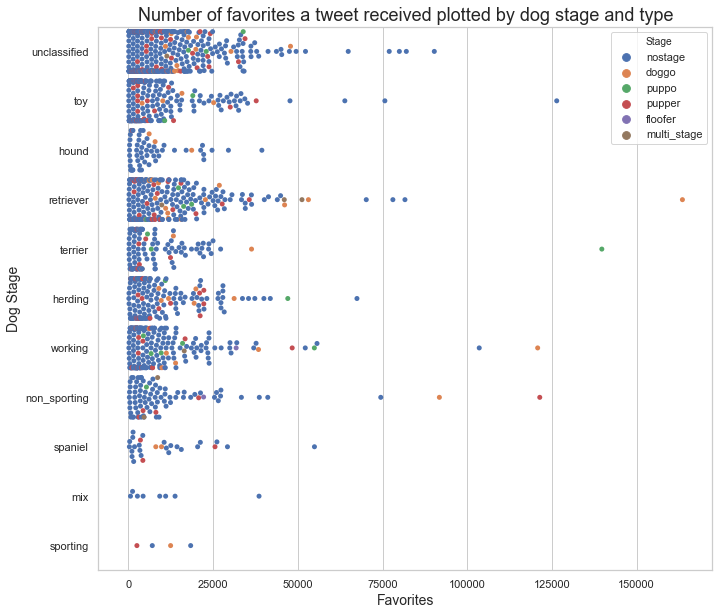

In [315]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(11, 10))
ax = sns.swarmplot(data=df1, x='favorite_cnt', y='breed_type', hue='stage')
ax.set_xlabel('Favorites', fontsize=14)
ax.set_ylabel('Dog Stage', fontsize=14)
ax.set_title('Number of favorites a tweet received plotted by dog stage and type',  fontsize=18)

ax.legend_.set_title('Stage')

fig = ax.get_figure()
fig.savefig('output.png') 

In [651]:
#f, ax = plt.subplots(figsize=(11, 10))
#ax = sns.scatterplot(y="stage", x="favorite_cnt", hue="breed_type", 
#               y_jitter=10, data=df1)
#ax.set(xlabel='Favorites', ylabel='Dog Stage')

In [ ]:
#sns.scatterplot(y="breed_type", x="favorite_cnt",  hue='stage',sizes=(20, 200),
#                alpha =0.5, y_jitter=10, data=df1)